In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

import src
from src.reload import deep_reload

In [2]:
gdf_zones = gpd.read_file('../charger_network_analysis/Data/NGOD/Shapes/V2_Zones.shp')

gdf_zones['in_california'] = gdf_zones['V2ZONEID'].apply(lambda zid: 'CA' in zid)

gdf_zones_california = gdf_zones[gdf_zones['in_california']]

gdf_zones_california = gdf_zones_california.explode(drop = True)

In [3]:
out_file_name = 'Outputs/routes_ns.json'

In [4]:
parameters = json.load(open('CEC/parameters_cec_router.json', 'rb'))

In [5]:
# Loading Info

graph = src.graph.graph_from_json('graph.json')

In [6]:
deep_reload(src)

graph = src.router.assign_rng(graph, seed = parameters['rng_seed'])

graph = src.router.assign_vehicle(graph, parameters['vehicles'])

In [7]:
deep_reload(src)

graph = src.rng.assign_link_parameters(graph, parameters)

In [8]:
deep_reload(src)

graph = src.rng.assign_node_parameters(graph, parameters)

In [9]:
case = parameters['vehicles']['Bolt']['cases'][0]

In [10]:
deep_reload(src)

graph = src.savings_stochastic.add_depot_legs(
    graph, parameters['depot_nodes'], case['objectives']
)

In [11]:
# graph._adj[list(graph.nodes)[0]]
times = []
for val in graph._adj[1000000000].values():
    times.append(val['time'].mean())

(array([ 62.,  83.,  93., 171., 224.,  81.,  37.,  42.,  67.,  29.,  11.,
         17.,  29.,  30.,  15.,  25., 156., 166., 173., 123.,  63., 111.,
        118.,  42.,  23.,   6.,   1.,   1.,   2.,   2.]),
 array([ 0.        ,  0.49920339,  0.99840679,  1.49761018,  1.99681358,
         2.49601697,  2.99522036,  3.49442376,  3.99362715,  4.49283055,
         4.99203394,  5.49123733,  5.99044073,  6.48964412,  6.98884752,
         7.48805091,  7.9872543 ,  8.4864577 ,  8.98566109,  9.48486449,
         9.98406788, 10.48327127, 10.98247467, 11.48167806, 11.98088146,
        12.48008485, 12.97928824, 13.47849164, 13.97769503, 14.47689843,
        14.97610182]),
 <BarContainer object of 30 artists>)

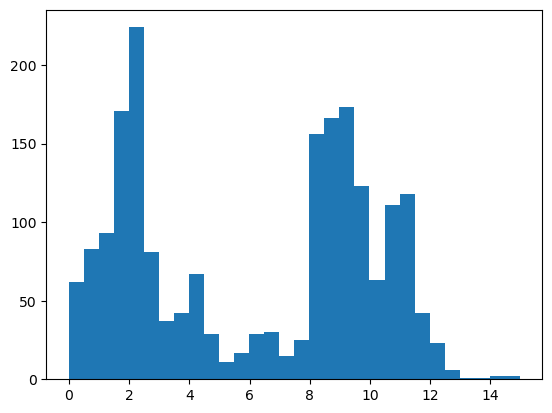

In [12]:
plt.hist(np.array(times) / 3600, bins = 30)

In [21]:
deep_reload(src)

kwargs = {
    'pb_kwargs': {
        'freq': 1000,
    },
}

final_routes = []

for vehicle_name, vehicle in parameters['vehicles'].items():

    keep_nodes = [k for k, v in graph._node.items() if vehicle_name in v['vehicle']]

    sg = src.graph.subgraph(
        graph, np.concatenate((keep_nodes, parameters['depot_nodes']))
    )

    for idx, case in enumerate(vehicle['cases']):
        
        objectives = case['objectives']

        routes, route_values, success = src.savings_stochastic.savings(
            sg, objectives, **kwargs,
        )

        routes = src.router.route_information(sg, routes, parameters['route_fields'])

        full_routes = []
        
        for idx, route in enumerate(routes):

            condition_1 = len(route['nodes']) > 3
            condition_2 = idx == len(vehicle['cases'])
    
            if condition_1 or condition_2:
        
                route['vehicle'] = vehicle_name

                for objective in objectives.keys():

                    route[objective] = route_values[idx][objective]
                    route[f'{objective}_expected'] = np.mean(route_values[idx][objective])

                full_routes.append(route)

        final_routes.extend(full_routes)
    
        all_nodes = np.array(list(sg.nodes))
        
        if full_routes:
            
            nodes_visited = np.unique(
                np.concatenate([r['nodes'] for r in full_routes])
            )
            
        else:
            
            nodes_visited = []
        
        nodes_not_visited = np.unique(
            np.concatenate((
                parameters['depot_nodes'],
                np.setdiff1d(all_nodes, nodes_visited)
            )))

        sg = src.graph.subgraph(sg, nodes_not_visited)

    break

 [>            ] (0/1) 0.00%, 524288.00 it/s, 0.00 s elapsed, 0.00 s remaining

In [22]:
len(final_routes)

187

In [23]:
final_routes[:5]

[{'Station Name': ['UC Riverside Depot',
   'IRVINE  CO  OFC IOP 120 04',
   'CARDINALEWAY SUPER ONE',
   'LEASING 1885 SPACE 3',
   'CSG EV CR2',
   'COC EV CHARGING CITY HALL 1',
   'UC Riverside Depot'],
  'City': ['Riverside',
   'Irvine',
   'Corona',
   'Corona',
   'Corona',
   'Corona',
   'Riverside'],
  'State': ['CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA'],
  'ZIP': [92507, 92618, 92882, 92882, 92882, 92882, 92507],
  'Longitude': [-117.325083,
   -117.761193,
   -117.613261,
   -117.592537,
   -117.592265,
   -117.575062,
   -117.325083],
  'Latitude': [33.97528758,
   33.678705,
   33.882387,
   33.862801,
   33.877589,
   33.878928,
   33.97528758],
  'DCFC': [0, 0, 1, 0, 1, 1, 0],
  'Network': ['Depot',
   'ChargePoint Network',
   'ChargePoint Network',
   'ChargePoint Network',
   'ChargePoint Network',
   'ChargePoint Network',
   'Depot'],
  'chargers': [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0],
  'nodes': [2000000000, 220992, 253797, 159368, 181126, 160557, 2000000000],
  'v

In [59]:
objectives = parameters['vehicles']['Bolt']['cases'][0]['objectives']

print(objectives)

# savings, initial_routes, initial_route_values = src.savings_stochastic.requisites(
#     sg, objectives, **kwargs
# )

{'time': {'route': [0, 864000], 'leg': [0, 864000], 'weight': 1}, 'length': {'route': [0, 14400], 'leg': [0, 14400], 'weight': 0}, 'price': {'route': [0, inf], 'leg': [0, inf], 'weight': 0}}


In [57]:
initial_route_values

[{'length': array([167780., 167780., 167780., 167780., 167780., 167780., 167780.,
         167780., 167780., 167780., 167780., 167780., 167780., 167780.,
         167780., 167780., 167780., 167780., 167780., 167780., 167780.,
         167780., 167780., 167780., 167780., 167780., 167780., 167780.,
         167780., 167780.]),
  'time': array([ 8707.01744303, 10947.74072206, 12045.07854928, 10469.17046093,
         11307.90283574, 11469.17413099, 12758.25172756,  9809.63855881,
         12490.86427672, 13913.90353842,  8678.28566432, 13209.46663553,
          8534.42827166, 10127.77998473, 13577.81611569, 10759.53675014,
         11207.14838461, 10697.5629867 ,  9679.54572804, 11990.80849461,
         12357.42830078, 10929.32496507, 11129.98059407,  9630.88382813,
         10892.6773482 , 11130.08600912, 11648.31174848, 12411.25529245,
         11888.00805433, 14046.10336129]),
  'price': array([19.27093117, 19.27093117, 19.27093117, 19.27093117, 19.27093117,
         19.27093117, 19.270

In [37]:
nodes_visited = np.concatenate([r['nodes'] for r in final_routes])
plot_sg = src.graph.subgraph(graph, nodes_visited)
len(final_routes), len(nodes_visited), len(np.unique(nodes_visited))

(71, 333, 194)

In [38]:
routes = np.random.choice(final_routes, len(final_routes), replace = False)

for route in routes:

    route_expected_time = route['time'].mean()
    
    if route_expected_time <= 4*3600:
        vn = .0
        route['type'] = '4 Hour'

    elif route_expected_time <= 8*3600:
        vn = .33
        route['type'] = '8 Hour'

    elif route_expected_time <= 16*3600:
        vn = .66
        route['type'] = '16 Hour'

    elif route_expected_time <= 24*3600:
        vn = .99
        route['type'] = '24 Hour'
        
    # print(route['vehicle'], vn)
    for n in route['nodes']:
        plot_sg._node[n]['route_vehicle'] = vn

In [39]:
src.graph.nlg_to_json(routes, out_file_name)

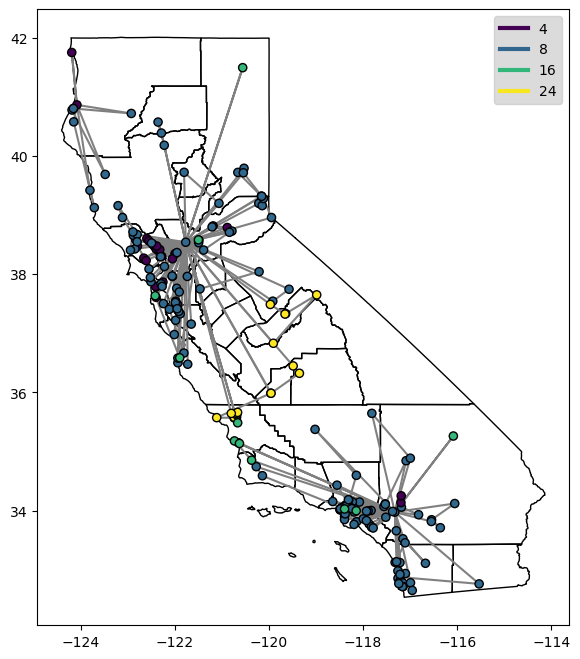

In [40]:
deep_reload(src)

kwargs = {
    'show_links': False,
    'node_field': 'route_vehicle',
    'scatter': {
        's': 35,
        'ec': 'k',
    },
    'line': {
        'color': 'gray',
        'zorder': 0,
    },
}

fig, ax = plt.subplots(figsize = (8, 8))

gdf_zones_california.plot(ax = ax, fc = 'none', ec = 'k', zorder = 0)


src.figures.plot_graph(plot_sg, ax = ax, **kwargs)
src.figures.plot_routes(plot_sg, routes, ax = ax, **kwargs)

from matplotlib.lines import Line2D

colors = src.figures.colormap('viridis')(np.array([0, .33, .66, .99]))
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
labels = ['4', '8', '16', '24']
ax.legend(lines, labels, facecolor = 'lightgray', markerscale = 40)